base_node_software_version                                                     
package_name                                                            dropbot
display_name                                                            DropBot
manufacturer                                                        Wheeler Lab
url                           http://github.com/wheeler-microfluidics/dropbo...
software_version                                                     1.8.post21
dtype: object

uuid			0000a1fa-3300-85a1-1000-2f00454e5337

i2c_scan: [10 32 33 34]
soft_i2c_scan: [44]
number of channels: 120

config:
max_voltage                        150
R7                             9536.95
min_frequency                      100
switching_board_i2c_address         32
max_frequency                    10000
pot_max                        47805.5
i2c_address                         10
id                                    
dtype: object
rms_error = 2.7%


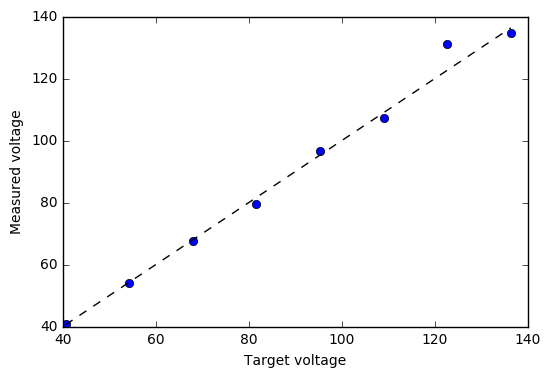

In [9]:
import time
import matplotlib.pyplot as plt
import numpy as np
from dropbot import SerialProxy
import pandas as pd

%matplotlib inline

try:
    del proxy
except:
    pass

# Connect to the connected DropBot and print it's properties
proxy = SerialProxy()

print proxy.properties

print "\nuuid\t\t\t%s\n" % proxy.uuid

#proxy.reset_config()
proxy.update_config(max_voltage=150, i2c_address=10)

print "i2c_scan:", proxy.i2c_scan()
print "soft_i2c_scan:", proxy.soft_i2c_scan()

proxy.initialize_switching_boards()

print "number of channels:", proxy.number_of_channels

print "\nconfig:"
print proxy.config

# test the measured voltage for a range of target voltages
proxy.voltage = proxy.min_waveform_voltage
proxy.hv_output_enabled = True
measured_voltage = []

voltage = np.linspace(proxy.min_waveform_voltage,
                      proxy.max_waveform_voltage,
                      10)[1:-1]
for v in voltage:
    proxy.voltage = v
    time.sleep(.5)
    measured_voltage.append(proxy.measured_voltage)

measured_voltage = np.array(measured_voltage)
proxy.voltage = proxy.min_waveform_voltage + 5

plt.figure()
# plot the measured vs target votage
plt.plot(voltage, measured_voltage, 'o')
plt.plot(voltage, voltage, 'k--')
plt.xlabel('Target voltage')
plt.ylabel('Measured voltage')

# calculate the average rms error
r = measured_voltage - voltage
print 'rms_error = %.1f%%' % (100 * np.sqrt(np.mean((r / voltage)**2)))

In [ ]:
# test channels using the test-board

def sample_feedback(i, plot=False, n_samples=50, gain_power=5):
    c = proxy.select_on_board_test_capacitor(i)
    time.sleep(.5)
    sampling_rate, adc_settings, df_volts, df_adc_results = proxy.analog_reads('PGA0', n_samples, gain_power=gain_power)
    v_gnd = np.mean(df_volts)
    v_rms = np.sqrt(np.mean((df_volts - v_gnd)**2))
    v_abs = np.mean(np.abs(df_volts - v_gnd))
    c_meas = v_abs.values[0] / proxy.voltage * 0.15e-6
    if plot:
        plt.figure()
        plt.plot(df_volts.values - v_gnd[0])
    return c_meas

proxy.voltage = 100
proxy.hv_output_enabled = True

start_time = time.time()
threshold = 5e-12
c = []
for i in range(0, 40):
    state = np.zeros(proxy.number_of_channels)
    state[i] = 1
    proxy.state_of_channels = state
    c.append(sample_feedback(-1, n_samples=50))
    if c[-1] < threshold:
        print "channel %d: %s (BAD)" % (i, c[-1])
    else:
        print "channel %d: %s" % (i, c[-1])

bad_count = np.count_nonzero(np.array(c) < 5e-12)
print "\nTest took %.1f s" % (time.time() - start_time)
print "%d of %d switches bad (%.1f %%)"  % (bad_count, len(c), float(bad_count) / len(c)*100)

plt.title('DropBot system: %s' % str(proxy.uuid)[-8:])
plt.bar(range(len(c)), c)

channel 0: 7.45340515137e-12
channel 1: 6.56149864197e-12
channel 2: 6.74451782227e-12
channel 3: 6.79379081726e-12
channel 4: 6.92449378967e-12
channel 5: 6.41230773926e-12
channel 6: 6.45702072144e-12
channel 7: 5.83463287354e-12
channel 8: 6.81131744385e-12
channel 9: 7.17312057495e-12
channel 10: 7.17987167358e-12
channel 11: 7.22397422791e-12
channel 12: 3.53848068237e-12 (BAD)
channel 13: 6.66691589355e-12
channel 14: 6.62952804565e-12
channel 15: 6.86368240356e-12
channel 16: 4.30082473755e-12 (BAD)
channel 17: 3.81155204773e-12 (BAD)
channel 18: 7.09478187561e-12
channel 19: 7.01248809814e-12
channel 20: 3.41436813354e-12 (BAD)
channel 21: 3.92244529724e-12 (BAD)
